## Import Libraries

importing Jupyter notebook from Utility.ipynb
importing Jupyter notebook from Collaborative_filtering.ipynb


/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


-0.019666189536321082 3.2872475852084366e-90
-0.00045459220224183735 0.6415722463057583


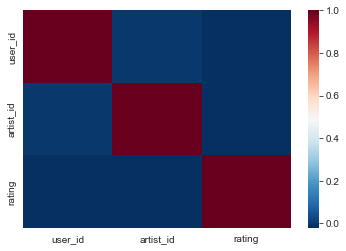

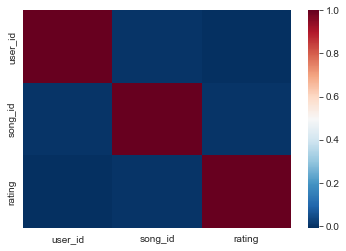

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import warnings
import import_ipynb
from Utility import *
from Collaborative_filtering import *

warnings.simplefilter(action='ignore', category=FutureWarning)
import random

warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

 ### Read Music Data by artists

In [2]:
data = pd.read_csv(r"datasets/data_by_artist.csv")
data.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


We only need **'valence', 'artists', 'count', 'popularity'** fields from the dataset. Hence, retrieving those fields and saving it in a csv file named as "artist_data.csv"


In [3]:
artist_data = data[['valence', 'artists', 'count', 'popularity']]
artist_data.to_csv('datasets/artist_data.csv')

## Hybrid Song Recommendation 

It is a recommendation system which is combination of the content and collaborative filtering method.  By using content and collaborative-based methods to generate predictions separately and then combining the prediction, we can generate more accurate recommendations and also reduces the problem of cold start.

1. **PCA_algorithm**: to reduce the dimensionality (in our case number of components is 2) within a dataset while still retaining as much information as possible.

2. **KMeans_with_PCA_algorithm**: algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping clusters. 
    Based on the values of the Within Cluster Sum of Squares (WCSS) and an approach known as the Elbow method, we made a decision about how many clusters we’d like to keep.In our case, we have kept number of cluster as 50.

3. we have then created a new data frame df_segm_pca_kmeans. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them com1 and com2.

4. **filter_based_on_segment**: filters songs that belong to particulat cluster segment.

5. **filter_based_on_cluster_centroid**: filters songs based on closet distance of song and centroid

6. returns list of top n artists, where n is set as 10 in our case

In [4]:
def recommend_artists(artist,  n=10):    
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    song_embedding = PCA_algorithm(artist_data)
    kmeans_pca, centroids = KMeans_with_PCA_algorithm(song_embedding,50)

    df_segm_pca_kmeans = pd.concat([artist_data.reset_index(drop=True), pd.DataFrame(song_embedding)], axis=1)
    df_segm_pca_kmeans.columns.values[-2:] = ['com1', 'com2']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    #get segment value of artist
    segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['artists'] == artist]['Segment K-means PCA'].values[0]

    filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans, segment_val,'artists', 'valence')

    rec_artists = filter_based_on_cluster_centroid(kmeans_pca, filtered_data_per_segment, segment_val, artist_data)

    #recommend top n artists
    return rec_artists.head(n)['artists'].tolist()

**recommend_artist_and_songs:** Finds list of songs and artists  based on the selected artist name 
Recommends Top N artist with their song(s). In  our case, we have recommended top 10 songs

In [5]:
def recommend_artist_and_songs(artist, n_songs=10):
    # get recommended artists
    recommended_artists = pd.DataFrame({
            'artist' : recommend_artists(artist, n_songs)
        })
    recommend_songs_list = pd.DataFrame(columns = ['artist', 'songs'])

    # get songs per artist
    for i in range(len(recommended_artists)):
        artist = recommended_artists.loc[i, "artist"]
        recommend_song = pd.DataFrame({
            'artist' : artist,
            'songs' : get_song_from_artist(artist, 1)
        })
        recommend_songs_list = recommend_songs_list.append(recommend_song, ignore_index = True)
    return  recommend_songs_list

**pass favorite artist name and no of recommended artist/song you want to listen and it gives you the list with n recommended artist with 1 songs per artist**

In [6]:
# recommended_artist_and_songs = recommend_artist_and_songs('Ella Fitzgerald',10)
# display(recommended_artist_and_songs)

In [7]:
def hybrid_filtering(artist_id, n_artist = 1):
    #collaborative filtering
    artist_data1 = pd.read_csv('datasets/ydata-ymusic-user-artist-rating.csv')
    artist_name_data1 = pd.read_csv('datasets/ydata-ymusic-artist-names.csv')
    recommended_artists_collab = collaborative_filtering(artist_data1,'artist_id', 'user_id', artist_id, n_artist, artist_name_data1)

    data1 = pd.read_csv(r"datasets/data_by_artist.csv")
    data2 = pd.read_csv(r"datasets/data.csv")

    # kmeans with pca
    recommended_artist_and_songs_hybrid = {}
    for val in recommended_artists_collab['artist']:
        if val in data1['artists'].values and any(val in s for s in data2['artists']):
            recommended_artist_and_songs_hybrid = recommend_artist_and_songs(val,10)

    return recommended_artist_and_songs_hybrid



In [8]:
# pass artist_id for hybrid filtering
results = hybrid_filtering(1058037)
display(results)

# Test IDS:
# 1001553
# 1058037

,artist,songs
0,Concrete Blonde,Bloodletting (The Vampire Song)
1,Walter Hawkins,Be Grateful
2,Lani Hall,How Can I Tell You
3,Bill Conti,Adrian
4,Danny Berrios,A Dios Sea La Gloria
5,Egg,Fugue In D Minor
6,鈴木 弘,ウォーク・トール
7,Miguel,#Beautiful
8,Glass Animals,Agnes
9,Sia,Alive


## Circle graph to show recommended songs

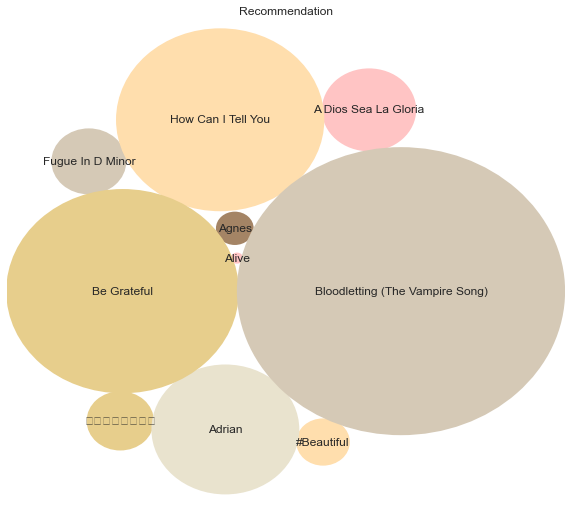

In [9]:
circlify_vizualization(results['songs'])

## Circle graph to show recommended Artists

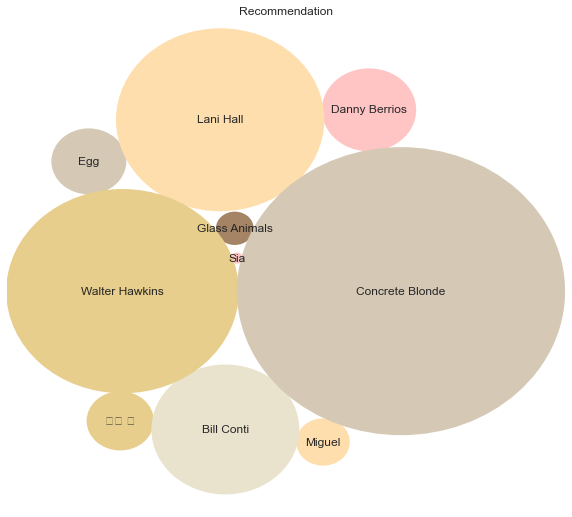

In [10]:
circlify_vizualization(results['artist'])